Usando dispositivo: cpu
📊 Tamaños → Train: 1600 | Val: 200 | Test: 200
Epoch 1/50 | Train 0.7752/0.3244 | Val 0.6508/0.5250 | F1 0.536
Epoch 2/50 | Train 0.7011/0.3881 | Val 0.6273/0.4750 | F1 0.417
Epoch 3/50 | Train 0.6653/0.4300 | Val 0.5533/0.5550 | F1 0.540
Epoch 4/50 | Train 0.6066/0.5019 | Val 0.5436/0.5750 | F1 0.549
Epoch 5/50 | Train 0.5765/0.5256 | Val 0.6124/0.5400 | F1 0.522
Epoch 6/50 | Train 0.5214/0.5769 | Val 0.5282/0.6100 | F1 0.575
Epoch 7/50 | Train 0.4854/0.6194 | Val 0.4385/0.6500 | F1 0.634
Epoch 8/50 | Train 0.4633/0.6412 | Val 0.6674/0.6000 | F1 0.581
Epoch 9/50 | Train 0.4420/0.6462 | Val 0.5066/0.6700 | F1 0.658
Epoch 10/50 | Train 0.4288/0.6619 | Val 0.5381/0.6150 | F1 0.606
Epoch 11/50 | Train 0.4221/0.6631 | Val 0.4181/0.7150 | F1 0.708
Epoch 12/50 | Train 0.3893/0.6975 | Val 0.5416/0.6650 | F1 0.658
Epoch 13/50 | Train 0.3917/0.6937 | Val 0.4363/0.6750 | F1 0.662
Epoch 14/50 | Train 0.3628/0.7238 | Val 0.4819/0.6750 | F1 0.663
Epoch 15/50 | Train 0.3321/0

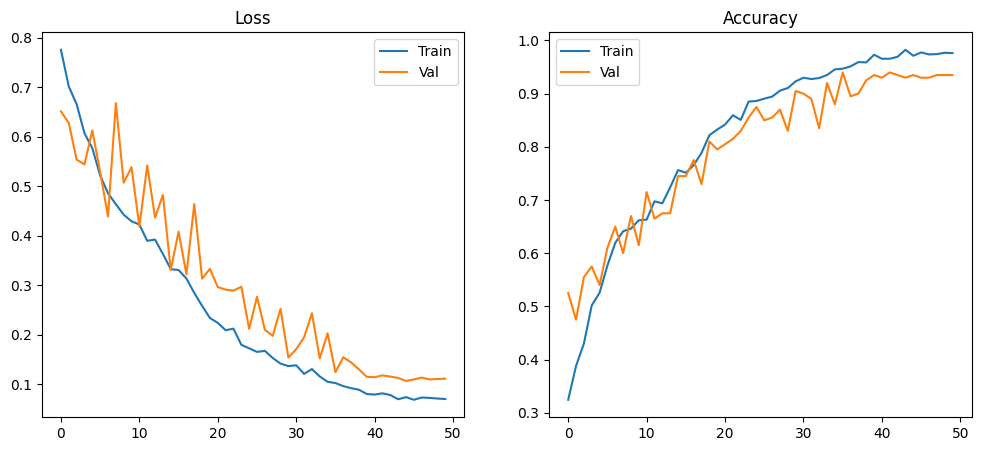

📊 Reporte Final:
                precision    recall  f1-score   support

      backhand       0.94      0.94      0.94        50
      forehand       0.85      0.80      0.82        50
ready_position       0.91      0.86      0.89        50
         serve       0.89      1.00      0.94        50

      accuracy                           0.90       200
     macro avg       0.90      0.90      0.90       200
  weighted avg       0.90      0.90      0.90       200

F1-score global: 0.8986841081501653


In [1]:
# =====================================================
# 🧠 CNN + MLP (con keypoints del JSON COCO-like)
# =====================================================
import os, json, random, copy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from torchvision.datasets import ImageFolder
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt

# =====================================================
# ⚙️ Configuración inicial
# =====================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)

# =====================================================
# 🔄 Transformaciones
# =====================================================
train_transform = transforms.Compose([
    transforms.RandomResizedCrop((128,128), scale=(0.7,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25),
    transforms.RandomAffine(0, translate=(0.1,0.1)),
    transforms.GaussianBlur(3),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])
val_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

# =====================================================
# 📦 Dataset multimodal con keypoints
# =====================================================
class TennisDataset(Dataset):
    def __init__(self, img_root, ann_root, transform=None):
        self.dataset = ImageFolder(img_root)
        self.classes = self.dataset.classes
        self.samples = self.dataset.samples
        self.transform = transform
        self.annotations = {}

        for cls in self.classes:
            jpath = os.path.join(ann_root, f"{cls}.json")
            if not os.path.exists(jpath):
                continue
            with open(jpath) as f:
                js = json.load(f)

            # Mapear IDs de imagen a nombres
            img_map = {img["id"]: img["file_name"] for img in js["images"]}
            for ann in js.get("annotations", []):
                img_name = img_map.get(ann["image_id"])
                if not img_name:
                    continue
                width = next((i["width"] for i in js["images"] if i["id"] == ann["image_id"]), 1280)
                height = next((i["height"] for i in js["images"] if i["id"] == ann["image_id"]), 720)

                keypoints = ann.get("keypoints", [])
                kp_xy = []
                for i in range(0, len(keypoints), 3):
                    x, y = keypoints[i], keypoints[i+1]
                    kp_xy.extend([x/width, y/height])
                while len(kp_xy) < 36:
                    kp_xy.append(0.0)

                self.annotations[img_name] = {
                    "width": width,
                    "height": height,
                    "id": ann["image_id"],
                    "keypoints": kp_xy
                }

    def __len__(self): 
        return len(self.samples)

    def __getitem__(self, i):
        img_path, label = self.samples[i]
        img = Image.open(img_path).convert("RGB")
        if self.transform: 
            img = self.transform(img)

        base = os.path.basename(img_path)
        meta = self.annotations.get(base, {
            "width": 1280, "height": 720, "id": 0, "keypoints": [0.0]*36
        })

        meta_vec = torch.tensor([
            meta["width"]/1280.0,
            meta["height"]/720.0,
            meta["id"]/10000.0,
            *meta["keypoints"]
        ], dtype=torch.float32)

        return img, meta_vec, label

# =====================================================
# 🧱 Bloque Residual
# =====================================================
class ResidualBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_c)
        )
        self.shortcut = nn.Conv2d(in_c, out_c, 1, bias=False) if in_c!=out_c else nn.Identity()
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        return self.relu(self.conv(x) + self.shortcut(x))

# =====================================================
# 🧩 Redes
# =====================================================
class ImageCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3,32,3,padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),
            ResidualBlock(32,64), nn.MaxPool2d(2),
            ResidualBlock(64,128), nn.MaxPool2d(2),
            ResidualBlock(128,256), nn.MaxPool2d(2)
        )
        self.flat = nn.Flatten()
        self.fc = nn.Sequential(nn.Linear(256*8*8,512), nn.ReLU(), nn.Dropout(0.3))
    def forward(self,x):
        return self.fc(self.flat(self.net(x)))

class MetaMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(39,128), nn.ReLU(),
            nn.Linear(128,64), nn.ReLU()
        )
    def forward(self,x): 
        return self.net(x)

class FusionModel(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.cnn = ImageCNN()
        self.mlp = MetaMLP()
        self.fc = nn.Sequential(
            nn.Linear(512+64,256), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(256,num_classes)
        )
    def forward(self,img,meta):
        v1=self.cnn(img)
        v2=self.mlp(meta)
        x=torch.cat([v1,v2],dim=1)
        return self.fc(x)

# =====================================================
# 🧮 División estratificada 80/10/10
# =====================================================
dataset_path = "c:/Users/USUARIO/Downloads/exam2_francoma/tennis/images"
ann_path = "c:/Users/USUARIO/Downloads/exam2_francoma/tennis/annotations"

full = TennisDataset(dataset_path, ann_path, transform=None)
indices = list(range(len(full)))
labels = [label for _, label in full.samples]

# 80% train, 10% val, 10% test con estratificación
train_idx, temp_idx, _, temp_labels = train_test_split(
    indices, labels, test_size=0.2, random_state=42, shuffle=True, stratify=labels
)
val_idx, test_idx = train_test_split(
    temp_idx, test_size=0.5, random_state=42, shuffle=True, stratify=temp_labels
)

train_set = Subset(TennisDataset(dataset_path, ann_path, transform=train_transform), train_idx)
val_set   = Subset(TennisDataset(dataset_path, ann_path, transform=val_transform), val_idx)
test_set  = Subset(TennisDataset(dataset_path, ann_path, transform=val_transform), test_idx)

trainL = DataLoader(train_set, batch_size=32, shuffle=True)
valL   = DataLoader(val_set, batch_size=32)
testL  = DataLoader(test_set, batch_size=32)
num_classes = len(full.classes)

# Mostrar tamaños
print(f"📊 Tamaños → Train: {len(train_set)} | Val: {len(val_set)} | Test: {len(test_set)}")

# =====================================================
# 🧠 Entrenamiento
# =====================================================
model = FusionModel(num_classes).to(device)

class FocalLoss(nn.Module):
    def __init__(self,alpha=1,gamma=2): 
        super().__init__(); self.alpha=alpha; self.gamma=gamma
    def forward(self,inputs,targets):
        ce = nn.functional.cross_entropy(inputs,targets,reduction="none",label_smoothing=0.1)
        pt = torch.exp(-ce)
        return (self.alpha*(1-pt)**self.gamma*ce).mean()

criterion = FocalLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, epochs=50, steps_per_epoch=len(trainL))

best, best_f1, patience, wait = copy.deepcopy(model.state_dict()), 0.0, 8, 0
train_loss, val_loss, train_acc, val_acc = [], [], [], []

for epoch in range(50):
    model.train(); run_loss=0; corr=0; tot=0
    for img,meta,lab in trainL:
        img,meta,lab=img.to(device),meta.to(device),lab.to(device)
        optimizer.zero_grad()
        out=model(img,meta)
        loss=criterion(out,lab)
        loss.backward(); optimizer.step(); scheduler.step()
        run_loss+=loss.item()*img.size(0)
        _,pred=torch.max(out,1)
        corr+=(pred==lab).sum().item(); tot+=lab.size(0)
    tr_loss=run_loss/tot; tr_acc=corr/tot
    train_loss.append(tr_loss); train_acc.append(tr_acc)

    # Validación
    model.eval(); v_loss=0; vc=0; vt=0; preds=[]; labs=[]
    with torch.no_grad():
        for img,meta,lab in valL:
            img,meta,lab=img.to(device),meta.to(device),lab.to(device)
            o=model(img,meta)
            l=criterion(o,lab)
            v_loss+=l.item()*img.size(0)
            _,p=torch.max(o,1)
            vc+=(p==lab).sum().item(); vt+=lab.size(0)
            preds+=p.cpu().tolist(); labs+=lab.cpu().tolist()
    v_loss/=vt; v_acc=vc/vt
    val_loss.append(v_loss); val_acc.append(v_acc)
    f1=f1_score(labs,preds,average="macro")

    print(f"Epoch {epoch+1}/50 | Train {tr_loss:.4f}/{tr_acc:.4f} | Val {v_loss:.4f}/{v_acc:.4f} | F1 {f1:.3f}")
    if f1>best_f1: best_f1=f1; best=copy.deepcopy(model.state_dict()); wait=0
    else:
        wait+=1
        if wait>=patience: print("⏹ Early stop"); break

# =====================================================
# 📈 Curvas
# =====================================================
plt.figure(figsize=(12,5))
plt.subplot(1,2,1); plt.plot(train_loss,label="Train"); plt.plot(val_loss,label="Val"); plt.title("Loss"); plt.legend()
plt.subplot(1,2,2); plt.plot(train_acc,label="Train"); plt.plot(val_acc,label="Val"); plt.title("Accuracy"); plt.legend()
plt.show()

# =====================================================
# 🧪 Evaluación final
# =====================================================
model.load_state_dict(best); model.eval()
preds,labels=[],[]
with torch.no_grad():
    for img,meta,lab in testL:
        img,meta,lab=img.to(device),meta.to(device),lab.to(device)
        o=model(img,meta)
        _,p=torch.max(o,1)
        preds+=p.cpu().tolist(); labels+=lab.cpu().tolist()

print("📊 Reporte Final:")
print(classification_report(labels,preds,target_names=full.classes))
print("F1-score global:", f1_score(labels,preds,average="macro"))


Usando dispositivo: cpu
Total muestras encontradas: 2000
  backhand: 500 imágenes
  forehand: 500 imágenes
  ready_position: 500 imágenes
  serve: 500 imágenes
📊 Tamaños → Train: 1600 | Val: 200 | Test: 200

🚀 Comienza entrenamiento...

Epoch 001/80 | Train 1.3012/0.3519 | Val 0.9583/0.5050 | F1 0.4446
Epoch 002/80 | Train 0.9218/0.5125 | Val 0.7814/0.5800 | F1 0.5752
Epoch 003/80 | Train 0.8653/0.5450 | Val 0.8024/0.5600 | F1 0.5607
Epoch 004/80 | Train 0.8467/0.5506 | Val 0.7268/0.6100 | F1 0.6110
Epoch 005/80 | Train 0.8117/0.5794 | Val 0.7430/0.6250 | F1 0.6213
Epoch 006/80 | Train 0.7585/0.5981 | Val 0.6962/0.6800 | F1 0.6827
Epoch 007/80 | Train 0.7204/0.6225 | Val 0.6115/0.6700 | F1 0.6642
Epoch 008/80 | Train 0.6942/0.6344 | Val 0.5875/0.7050 | F1 0.6960
Epoch 009/80 | Train 0.6742/0.6469 | Val 0.6378/0.6700 | F1 0.6732
Epoch 010/80 | Train 0.6588/0.6587 | Val 0.5776/0.7200 | F1 0.7126
Epoch 011/80 | Train 0.6189/0.6881 | Val 0.6044/0.6700 | F1 0.6722
Epoch 012/80 | Train 0.631

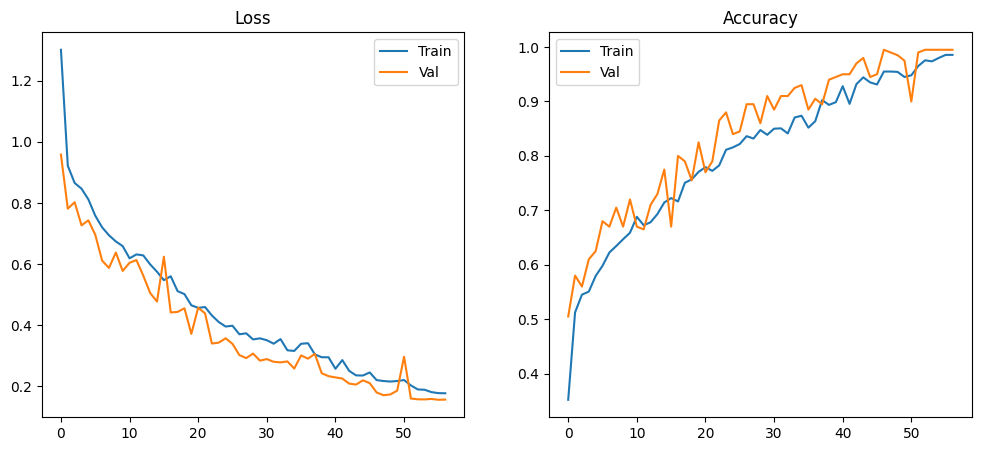


📊 Reporte Final:
                precision    recall  f1-score   support

      backhand       0.94      1.00      0.97        50
      forehand       0.98      0.94      0.96        50
ready_position       1.00      0.98      0.99        50
         serve       1.00      1.00      1.00        50

      accuracy                           0.98       200
     macro avg       0.98      0.98      0.98       200
  weighted avg       0.98      0.98      0.98       200

F1 global: 0.9799891124440362

✅ Modelo guardado como 'fusion_model_best.pth'


In [1]:
# =====================================================
# 🧠 CNN + MLP (con keypoints del JSON COCO-like) - Versión estable y con logs
# =====================================================
import os, json, random, copy
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from torchvision.datasets import ImageFolder
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt

# =====================================================
# ⚙️ Reproducibilidad
# =====================================================
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# =====================================================
# ⚙️ Configuración
# =====================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)

# =====================================================
# 🔄 Transformaciones
# =====================================================
train_transform = transforms.Compose([
    transforms.RandomResizedCrop((128,128), scale=(0.6,1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(25),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.RandomAffine(degrees=0, translate=(0.15,0.15), shear=10),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])
val_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

# =====================================================
# 📦 Dataset multimodal
# =====================================================
class TennisDataset(Dataset):
    def __init__(self, img_root, ann_root, transform=None):
        self.dataset = ImageFolder(img_root)
        self.classes = self.dataset.classes
        self.samples = self.dataset.samples
        self.transform = transform
        self.annotations = {}

        for cls in self.classes:
            jpath = os.path.join(ann_root, f"{cls}.json")
            if not os.path.exists(jpath):
                continue
            with open(jpath) as f:
                js = json.load(f)
            img_map = {img["id"]: img["file_name"] for img in js.get("images", [])}
            for ann in js.get("annotations", []):
                img_name = img_map.get(ann["image_id"])
                if not img_name:
                    continue
                width = next((i["width"] for i in js.get("images", []) if i["id"] == ann["image_id"]), 1280)
                height = next((i["height"] for i in js.get("images", []) if i["id"] == ann["image_id"]), 720)
                keypoints = ann.get("keypoints", [])
                kp_xy = []
                for i in range(0, len(keypoints), 3):
                    x, y = keypoints[i], keypoints[i+1]
                    kp_xy.extend([x/width if width else 0.0, y/height if height else 0.0])
                while len(kp_xy) < 36:
                    kp_xy.append(0.0)
                self.annotations[img_name] = {
                    "width": width,
                    "height": height,
                    "id": ann["image_id"],
                    "keypoints": kp_xy
                }

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, i):
        img_path, label = self.samples[i]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        base = os.path.basename(img_path)
        meta = self.annotations.get(base, {
            "width": 1280, "height": 720, "id": 0, "keypoints": [0.0]*36
        })
        meta_vec = torch.tensor([
            meta["width"]/1280.0,
            meta["height"]/720.0,
            meta["id"]/10000.0,
            *meta["keypoints"]
        ], dtype=torch.float32)
        return img, meta_vec, label

# =====================================================
# 🧱 Bloques
# =====================================================
class ResidualBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_c, momentum=0.05),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_c, momentum=0.05)
        )
        self.shortcut = nn.Conv2d(in_c, out_c, 1, bias=False) if in_c!=out_c else nn.Identity()
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        return self.relu(self.conv(x) + self.shortcut(x))

class ImageCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3,32,3,padding=1), nn.BatchNorm2d(32, momentum=0.05), nn.ReLU(), nn.MaxPool2d(2),
            ResidualBlock(32,64), nn.MaxPool2d(2),
            ResidualBlock(64,128), nn.MaxPool2d(2),
            ResidualBlock(128,256), nn.MaxPool2d(2)
        )
        self.flat = nn.Flatten()
        self.fc = nn.Sequential(nn.Linear(256*8*8,512), nn.ReLU(), nn.Dropout(0.4))
    def forward(self,x):
        return self.fc(self.flat(self.net(x)))

class MetaMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(39,128), nn.ReLU(),
            nn.Linear(128,64), nn.ReLU()
        )
    def forward(self,x): 
        return self.net(x)

class FusionModel(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.cnn = ImageCNN()
        self.mlp = MetaMLP()
        self.fc = nn.Sequential(
            nn.Linear(512+64,256), nn.ReLU(), nn.Dropout(0.4),
            nn.Linear(256,num_classes)
        )
    def forward(self,img,meta):
        v1=self.cnn(img)
        v2=self.mlp(meta)
        x=torch.cat([v1,v2],dim=1)
        return self.fc(x)

# =====================================================
# 🧮 División 80/10/10 (manteniendo tu método original)
# =====================================================
dataset_path = "c:/Users/USUARIO/Downloads/exam2_francoma/tennis/images"
ann_path = "c:/Users/USUARIO/Downloads/exam2_francoma/tennis/annotations"

full = TennisDataset(dataset_path, ann_path, transform=None)

print(f"Total muestras encontradas: {len(full)}")
for cls in full.classes:
    count = sum(1 for p, l in full.samples if full.classes[l] == cls)
    print(f"  {cls}: {count} imágenes")

indices = list(range(len(full)))
labels = [label for _, label in full.samples]

train_idx, temp_idx, _, temp_labels = train_test_split(
    indices, labels, test_size=0.2, random_state=SEED, shuffle=True, stratify=labels
)
val_idx, test_idx = train_test_split(
    temp_idx, test_size=0.5, random_state=SEED, shuffle=True, stratify=temp_labels
)

train_set = Subset(TennisDataset(dataset_path, ann_path, transform=train_transform), train_idx)
val_set   = Subset(TennisDataset(dataset_path, ann_path, transform=val_transform), val_idx)
test_set  = Subset(TennisDataset(dataset_path, ann_path, transform=val_transform), test_idx)

print(f"📊 Tamaños → Train: {len(train_set)} | Val: {len(val_set)} | Test: {len(test_set)}")

# =====================================================
# 🧠 Entrenamiento
# =====================================================
model = FusionModel(num_classes=len(full.classes)).to(device)

class ComboLoss(nn.Module):
    def __init__(self, alpha=0.5, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
    def forward(self, inputs, targets):
        ce = nn.functional.cross_entropy(inputs, targets, label_smoothing=0.05)
        pt = torch.exp(-ce)
        focal = ((1-pt)**self.gamma * ce).mean()
        return self.alpha * ce + (1 - self.alpha) * focal

criterion = ComboLoss(alpha=0.6, gamma=2.0)
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

best_state, best_f1, patience, wait = copy.deepcopy(model.state_dict()), 0.0, 10, 0
train_loss, val_loss, train_acc, val_acc = [], [], [], []
EPOCHS = 80

trainL = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=0)
valL   = DataLoader(val_set, batch_size=32, shuffle=False, num_workers=0)
testL  = DataLoader(test_set, batch_size=32, shuffle=False, num_workers=0)

print("\n🚀 Comienza entrenamiento...\n")

for epoch in range(EPOCHS):
    model.train()
    run_loss, corr, tot = 0, 0, 0
    for img, meta, lab in trainL:
        img, meta, lab = img.to(device), meta.to(device), lab.to(device)
        optimizer.zero_grad()
        out = model(img, meta)
        loss = criterion(out, lab)
        loss.backward(); optimizer.step()
        run_loss += loss.item() * img.size(0)
        _, pred = torch.max(out, 1)
        corr += (pred == lab).sum().item()
        tot += lab.size(0)
    tr_loss, tr_acc = run_loss / tot, corr / tot
    train_loss.append(tr_loss); train_acc.append(tr_acc)

    # Validación
    model.eval(); v_loss, vc, vt, preds, labs = 0, 0, 0, [], []
    with torch.no_grad():
        for img, meta, lab in valL:
            img, meta, lab = img.to(device), meta.to(device), lab.to(device)
            out = model(img, meta)
            l = criterion(out, lab)
            v_loss += l.item() * img.size(0)
            _, p = torch.max(out, 1)
            vc += (p == lab).sum().item(); vt += lab.size(0)
            preds += p.cpu().tolist(); labs += lab.cpu().tolist()
    v_loss /= vt; v_acc = vc / vt
    val_loss.append(v_loss); val_acc.append(v_acc)
    f1 = f1_score(labs, preds, average='macro') if len(set(labs)) > 1 else 0.0

    old_lr = optimizer.param_groups[0]['lr']
    scheduler.step(f1)
    new_lr = optimizer.param_groups[0]['lr']
    if new_lr < old_lr:
        print(f"📉 LR reducido: {old_lr:.6f} → {new_lr:.6f}")

    print(f"Epoch {epoch+1:03d}/{EPOCHS} | "
          f"Train {tr_loss:.4f}/{tr_acc:.4f} | "
          f"Val {v_loss:.4f}/{v_acc:.4f} | F1 {f1:.4f}")

    if f1 > best_f1:
        best_f1 = f1; best_state = copy.deepcopy(model.state_dict()); wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("⏹ Early stopping por paciencia alcanzada.")
            break

# =====================================================
# 📈 Curvas
# =====================================================
plt.figure(figsize=(12,5))
plt.subplot(1,2,1); plt.plot(train_loss,label="Train"); plt.plot(val_loss,label="Val"); plt.title("Loss"); plt.legend()
plt.subplot(1,2,2); plt.plot(train_acc,label="Train"); plt.plot(val_acc,label="Val"); plt.title("Accuracy"); plt.legend()
plt.show()

# =====================================================
# 🧪 Evaluación final
# =====================================================
model.load_state_dict(best_state); model.eval()
preds, labels = [], []
with torch.no_grad():
    for img, meta, lab in testL:
        img, meta, lab = img.to(device), meta.to(device), lab.to(device)
        out = model(img, meta)
        _, p = torch.max(out, 1)
        preds += p.cpu().tolist(); labels += lab.cpu().tolist()

print("\n📊 Reporte Final:")
print(classification_report(labels, preds, target_names=full.classes))
print("F1 global:", f1_score(labels, preds, average='macro'))

torch.save({'model_state_dict': best_state, 'classes': full.classes}, 'fusion_model_best.pth')
print("\n✅ Modelo guardado como 'fusion_model_best.pth'")


Usando dispositivo: cpu

Total muestras encontradas: 2000
  backhand: 500 imágenes
  forehand: 500 imágenes
  ready_position: 500 imágenes
  serve: 500 imágenes

📊 División 80/10/10 (requisito obligatorio):
   Train: 1600 muestras (80.0%)
   Val:   200 muestras (10.0%)
   Test:  200 muestras (10.0%)

🚀 CONFIGURACIÓN DE ENTRENAMIENTO
Epochs:         60
Batch size:     16 (batches por epoch: 100)
Learning rate:  0.0005
Weight decay:   0.0005
Dropout:        0.3
Early stopping: 10 epochs

Epoch 01/60 | Loss: 1.3827/1.1603 | Acc: 0.3581/0.5800 | F1: 0.5791 ✨
Epoch 02/60 | Loss: 1.1812/1.0889 | Acc: 0.5169/0.5250 | F1: 0.4755
Epoch 03/60 | Loss: 1.1331/1.0688 | Acc: 0.5375/0.5500 | F1: 0.5534
Epoch 04/60 | Loss: 1.1074/1.1091 | Acc: 0.5725/0.5750 | F1: 0.5412
Epoch 05/60 | Loss: 1.0797/0.9914 | Acc: 0.5887/0.6450 | F1: 0.6430 ✨
Epoch 06/60 | Loss: 1.0639/0.9845 | Acc: 0.6006/0.6500 | F1: 0.6424
Epoch 07/60 | Loss: 1.0040/0.9454 | Acc: 0.6338/0.6400 | F1: 0.6344
Epoch 08/60 | Loss: 0.9721/0.

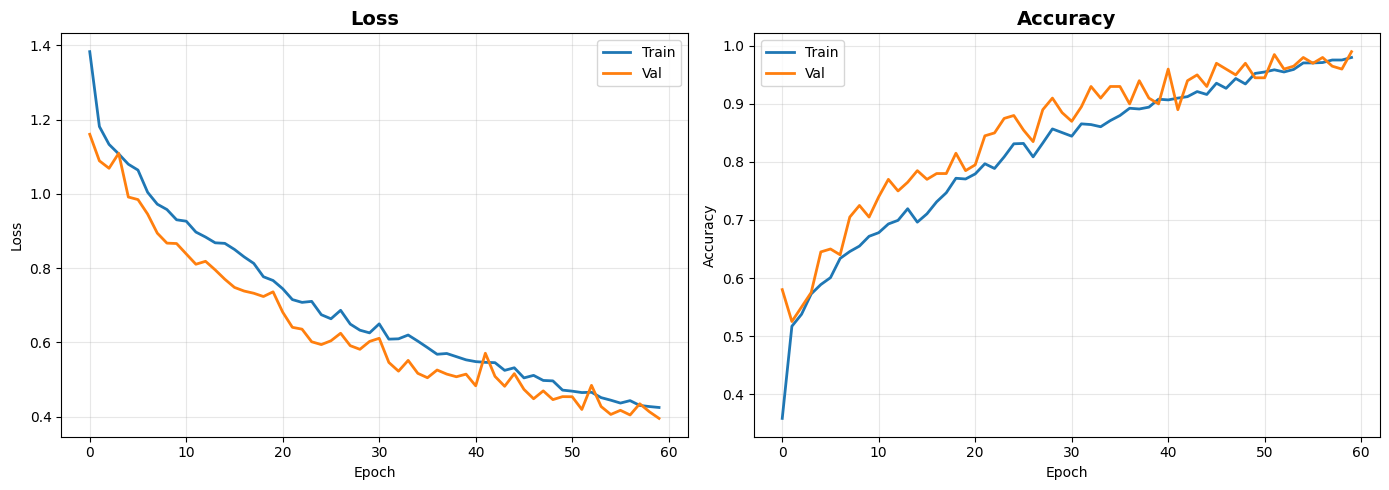

🧪 EVALUACIÓN EN TEST SET

                precision    recall  f1-score   support

      backhand       0.98      1.00      0.99        50
      forehand       1.00      0.94      0.97        50
ready_position       0.96      1.00      0.98        50
         serve       1.00      1.00      1.00        50

      accuracy                           0.98       200
     macro avg       0.99      0.98      0.98       200
  weighted avg       0.99      0.98      0.98       200


🎯 F1-Score Macro: 0.9849

✅ Modelo guardado como 'fusion_model_optimized.pth'

📋 Resumen:
   Mejor Val F1:  0.9900
   Test F1:       0.9849
   Epochs:        60/60
   LR final:      0.000350



In [2]:
# =====================================================
# 🧠 CNN + MLP OPTIMIZADO - Versión mejorada para dataset pequeño
# =====================================================
import os, json, random, copy
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from torchvision.datasets import ImageFolder
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt

# =====================================================
# ⚙️ Reproducibilidad
# =====================================================
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# =====================================================
# ⚙️ Configuración optimizada
# =====================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)

EPOCHS = 60          # Ajustado para dataset pequeño
BATCH_SIZE = 16      # Reducido de 32 para más batches/epoch
LEARNING_RATE = 5e-4 # Reducido de 1e-3
WEIGHT_DECAY = 5e-4  # Aumentado de 1e-4
PATIENCE = 10        # Conservador para early stopping
DROPOUT = 0.3        # Reducido de 0.4

# =====================================================
# 🔄 Transformaciones menos agresivas
# =====================================================
train_transform = transforms.Compose([
    transforms.Resize((140,140)),  # Pre-resize
    transforms.RandomResizedCrop((128,128), scale=(0.8,1.0)),  # Menos agresivo (era 0.6-1.0)
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),  # Reducido de 25
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Reducido de 0.3
    # ❌ Eliminados RandomAffine y RandomPerspective (muy agresivos)
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

val_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

# =====================================================
# 📦 Dataset multimodal (sin cambios)
# =====================================================
class TennisDataset(Dataset):
    def __init__(self, img_root, ann_root, transform=None):
        self.dataset = ImageFolder(img_root)
        self.classes = self.dataset.classes
        self.samples = self.dataset.samples
        self.transform = transform
        self.annotations = {}

        for cls in self.classes:
            jpath = os.path.join(ann_root, f"{cls}.json")
            if not os.path.exists(jpath):
                continue
            with open(jpath) as f:
                js = json.load(f)
            img_map = {img["id"]: img["file_name"] for img in js.get("images", [])}
            for ann in js.get("annotations", []):
                img_name = img_map.get(ann["image_id"])
                if not img_name:
                    continue
                width = next((i["width"] for i in js.get("images", []) if i["id"] == ann["image_id"]), 1280)
                height = next((i["height"] for i in js.get("images", []) if i["id"] == ann["image_id"]), 720)
                keypoints = ann.get("keypoints", [])
                kp_xy = []
                for i in range(0, len(keypoints), 3):
                    x, y = keypoints[i], keypoints[i+1]
                    kp_xy.extend([x/width if width else 0.0, y/height if height else 0.0])
                while len(kp_xy) < 36:
                    kp_xy.append(0.0)
                self.annotations[img_name] = {
                    "width": width,
                    "height": height,
                    "id": ann["image_id"],
                    "keypoints": kp_xy
                }

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, i):
        img_path, label = self.samples[i]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        base = os.path.basename(img_path)
        meta = self.annotations.get(base, {
            "width": 1280, "height": 720, "id": 0, "keypoints": [0.0]*36
        })
        meta_vec = torch.tensor([
            meta["width"]/1280.0,
            meta["height"]/720.0,
            meta["id"]/10000.0,
            *meta["keypoints"]
        ], dtype=torch.float32)
        return img, meta_vec, label

# =====================================================
# 🧱 Bloques con BatchNorm optimizado
# =====================================================
class ResidualBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_c, momentum=0.1),  # Cambiado de 0.05 a 0.1
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_c, momentum=0.1)   # Cambiado de 0.05 a 0.1
        )
        self.shortcut = nn.Conv2d(in_c, out_c, 1, bias=False) if in_c!=out_c else nn.Identity()
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, x):
        return self.relu(self.conv(x) + self.shortcut(x))

class ImageCNN(nn.Module):
    def __init__(self, dropout=DROPOUT):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3,32,3,padding=1), 
            nn.BatchNorm2d(32, momentum=0.1),  # Cambiado de 0.05
            nn.ReLU(), 
            nn.MaxPool2d(2),
            ResidualBlock(32,64), 
            nn.MaxPool2d(2),
            ResidualBlock(64,128), 
            nn.MaxPool2d(2),
            ResidualBlock(128,256), 
            nn.MaxPool2d(2)
        )
        self.flat = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(256*8*8,512), 
            nn.ReLU(), 
            nn.Dropout(dropout)  # Reducido de 0.4 a 0.3
        )
    
    def forward(self,x):
        return self.fc(self.flat(self.net(x)))

class MetaMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(39,128), 
            nn.ReLU(),
            nn.Linear(128,64), 
            nn.ReLU()
        )
    
    def forward(self,x): 
        return self.net(x)

class FusionModel(nn.Module):
    def __init__(self, num_classes, dropout=DROPOUT):
        super().__init__()
        self.cnn = ImageCNN(dropout=dropout)
        self.mlp = MetaMLP()
        self.fc = nn.Sequential(
            nn.Linear(512+64,256), 
            nn.ReLU(), 
            nn.Dropout(dropout),  # Reducido de 0.4
            nn.Linear(256,num_classes)
        )
    
    def forward(self,img,meta):
        v1=self.cnn(img)
        v2=self.mlp(meta)
        x=torch.cat([v1,v2],dim=1)
        return self.fc(x)

# =====================================================
# 🧮 División 80/10/10 (OBLIGATORIO por requisitos)
# =====================================================
dataset_path = "c:/Users/USUARIO/Downloads/exam2_francoma/tennis/images"
ann_path = "c:/Users/USUARIO/Downloads/exam2_francoma/tennis/annotations"

full = TennisDataset(dataset_path, ann_path, transform=None)

print(f"\n{'='*60}")
print(f"Total muestras encontradas: {len(full)}")
for cls in full.classes:
    count = sum(1 for p, l in full.samples if full.classes[l] == cls)
    print(f"  {cls}: {count} imágenes")
print(f"{'='*60}\n")

indices = list(range(len(full)))
labels = [label for _, label in full.samples]

# Split 80/10/10 (REQUISITO OBLIGATORIO - SEED 42)
train_idx, temp_idx, _, temp_labels = train_test_split(
    indices, labels, test_size=0.2, random_state=SEED, shuffle=True, stratify=labels
)
val_idx, test_idx = train_test_split(
    temp_idx, test_size=0.5, random_state=SEED, shuffle=True, stratify=temp_labels
)

train_set = Subset(TennisDataset(dataset_path, ann_path, transform=train_transform), train_idx)
val_set   = Subset(TennisDataset(dataset_path, ann_path, transform=val_transform), val_idx)
test_set  = Subset(TennisDataset(dataset_path, ann_path, transform=val_transform), test_idx)

print(f"📊 División 80/10/10 (requisito obligatorio):")
print(f"   Train: {len(train_set)} muestras ({len(train_set)/len(full)*100:.1f}%)")
print(f"   Val:   {len(val_set)} muestras ({len(val_set)/len(full)*100:.1f}%)")
print(f"   Test:  {len(test_set)} muestras ({len(test_set)/len(full)*100:.1f}%)\n")

# =====================================================
# 🧠 Entrenamiento con hiperparámetros optimizados
# =====================================================
model = FusionModel(num_classes=len(full.classes)).to(device)

# Loss simplificado (eliminado Focal Loss)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Optimizer más conservador
optimizer = optim.AdamW(
    model.parameters(), 
    lr=LEARNING_RATE,      # 5e-4 (antes 1e-3)
    weight_decay=WEIGHT_DECAY  # 5e-4 (antes 1e-4)
)

# Scheduler menos agresivo
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='max', 
    factor=0.7,    # Antes 0.5
    patience=5,    # Antes 3
)

best_state, best_f1, wait = copy.deepcopy(model.state_dict()), 0.0, 0
train_loss, val_loss, train_acc, val_acc = [], [], [], []

# DataLoaders con batch size reducido
trainL = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
valL   = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
testL  = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"{'='*60}")
print(f"🚀 CONFIGURACIÓN DE ENTRENAMIENTO")
print(f"{'='*60}")
print(f"Epochs:         {EPOCHS}")
print(f"Batch size:     {BATCH_SIZE} (batches por epoch: {len(trainL)})")
print(f"Learning rate:  {LEARNING_RATE}")
print(f"Weight decay:   {WEIGHT_DECAY}")
print(f"Dropout:        {DROPOUT}")
print(f"Early stopping: {PATIENCE} epochs")
print(f"{'='*60}\n")

for epoch in range(EPOCHS):
    # ===== ENTRENAMIENTO =====
    model.train()
    run_loss, corr, tot = 0, 0, 0
    for img, meta, lab in trainL:
        img, meta, lab = img.to(device), meta.to(device), lab.to(device)
        optimizer.zero_grad()
        out = model(img, meta)
        loss = criterion(out, lab)
        loss.backward()
        optimizer.step()
        
        run_loss += loss.item() * img.size(0)
        _, pred = torch.max(out, 1)
        corr += (pred == lab).sum().item()
        tot += lab.size(0)
    
    tr_loss, tr_acc = run_loss / tot, corr / tot
    train_loss.append(tr_loss)
    train_acc.append(tr_acc)

    # ===== VALIDACIÓN =====
    model.eval()
    v_loss, vc, vt, preds, labs = 0, 0, 0, [], []
    with torch.no_grad():
        for img, meta, lab in valL:
            img, meta, lab = img.to(device), meta.to(device), lab.to(device)
            out = model(img, meta)
            l = criterion(out, lab)
            v_loss += l.item() * img.size(0)
            _, p = torch.max(out, 1)
            vc += (p == lab).sum().item()
            vt += lab.size(0)
            preds += p.cpu().tolist()
            labs += lab.cpu().tolist()
    
    v_loss /= vt
    v_acc = vc / vt
    val_loss.append(v_loss)
    val_acc.append(v_acc)
    f1 = f1_score(labs, preds, average='macro') if len(set(labs)) > 1 else 0.0

    # ===== SCHEDULER =====
    old_lr = optimizer.param_groups[0]['lr']
    scheduler.step(f1)
    new_lr = optimizer.param_groups[0]['lr']
    
    # ===== LOG =====
    log_msg = (f"Epoch {epoch+1:02d}/{EPOCHS} | "
               f"Loss: {tr_loss:.4f}/{v_loss:.4f} | "
               f"Acc: {tr_acc:.4f}/{v_acc:.4f} | "
               f"F1: {f1:.4f}")
    
    if new_lr < old_lr:
        log_msg += f" | 📉 LR: {old_lr:.6f}→{new_lr:.6f}"
    
    if f1 > best_f1:
        log_msg += " ✨"
        best_f1 = f1
        best_state = copy.deepcopy(model.state_dict())
        wait = 0
    else:
        wait += 1
    
    print(log_msg)
    
    # ===== EARLY STOPPING =====
    if wait >= PATIENCE:
        print(f"\n⏹ Early stopping activado en epoch {epoch+1}")
        print(f"   Mejor F1: {best_f1:.4f} (hace {wait} epochs)")
        break

# =====================================================
# 📈 Curvas de entrenamiento
# =====================================================
print(f"\n{'='*60}")
print("📈 Generando curvas...")
print(f"{'='*60}\n")

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(train_loss, label="Train", linewidth=2)
plt.plot(val_loss, label="Val", linewidth=2)
plt.title("Loss", fontsize=14, fontweight='bold')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1,2,2)
plt.plot(train_acc, label="Train", linewidth=2)
plt.plot(val_acc, label="Val", linewidth=2)
plt.title("Accuracy", fontsize=14, fontweight='bold')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# =====================================================
# 🧪 Evaluación final en Test Set
# =====================================================
print(f"{'='*60}")
print("🧪 EVALUACIÓN EN TEST SET")
print(f"{'='*60}\n")

model.load_state_dict(best_state)
model.eval()
preds, labels = [], []

with torch.no_grad():
    for img, meta, lab in testL:
        img, meta, lab = img.to(device), meta.to(device), lab.to(device)
        out = model(img, meta)
        _, p = torch.max(out, 1)
        preds += p.cpu().tolist()
        labels += lab.cpu().tolist()

print(classification_report(labels, preds, target_names=full.classes))
final_f1 = f1_score(labels, preds, average='macro')
print(f"\n🎯 F1-Score Macro: {final_f1:.4f}")

# =====================================================
# 💾 Guardar modelo
# =====================================================
save_dict = {
    'model_state_dict': best_state,
    'classes': full.classes,
    'config': {
        'epochs_trained': epoch + 1,
        'best_val_f1': best_f1,
        'final_test_f1': final_f1,
        'learning_rate': LEARNING_RATE,
        'batch_size': BATCH_SIZE,
        'dropout': DROPOUT
    }
}
torch.save(save_dict, 'fusion_model_optimized.pth')

print(f"\n{'='*60}")
print("✅ Modelo guardado como 'fusion_model_optimized.pth'")
print(f"{'='*60}")
print(f"\n📋 Resumen:")
print(f"   Mejor Val F1:  {best_f1:.4f}")
print(f"   Test F1:       {final_f1:.4f}")
print(f"   Epochs:        {epoch + 1}/{EPOCHS}")
print(f"   LR final:      {optimizer.param_groups[0]['lr']:.6f}")
print(f"{'='*60}\n")

In [8]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import json, os

# =====================================================
# 🧱 MISMA ARQUITECTURA
# =====================================================
class ResidualBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_c, momentum=0.1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_c, momentum=0.1)
        )
        self.shortcut = nn.Conv2d(in_c, out_c, 1, bias=False) if in_c != out_c else nn.Identity()
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.conv(x) + self.shortcut(x))

class ImageCNN(nn.Module):
    def __init__(self, dropout=0.3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3,32,3,padding=1),
            nn.BatchNorm2d(32, momentum=0.1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            ResidualBlock(32,64),
            nn.MaxPool2d(2),
            ResidualBlock(64,128),
            nn.MaxPool2d(2),
            ResidualBlock(128,256),
            nn.MaxPool2d(2)
        )
        self.flat = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(256*8*8,512),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.fc(self.flat(self.net(x)))

class MetaMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(39,128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU()
        )

    def forward(self, x):
        return self.net(x)

class FusionModel(nn.Module):
    def __init__(self, num_classes, dropout=0.3):
        super().__init__()
        self.cnn = ImageCNN(dropout=dropout)
        self.mlp = MetaMLP()
        self.fc = nn.Sequential(
            nn.Linear(512+64,256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256,num_classes)
        )

    def forward(self, img, meta):
        v1 = self.cnn(img)
        v2 = self.mlp(meta)
        x = torch.cat([v1, v2], dim=1)
        return self.fc(x)

# =====================================================
# ⚙️ Cargar el modelo entrenado
# =====================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint = torch.load("fusion_model_optimized.pth", map_location=device)

classes = checkpoint['classes']
model = FusionModel(num_classes=len(classes))
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()

print("✅ Modelo cargado correctamente.")
print("Clases:", classes)

# =====================================================
# 🔄 Transformaciones (idénticas al val_transform)
# =====================================================
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

# =====================================================
# 🧩 Función para obtener metadatos desde JSON
# =====================================================
def get_meta_vector(img_name, ann_root, width=1280, height=720):
    """Busca el archivo JSON correspondiente y devuelve el vector meta."""
    cls = os.path.basename(os.path.dirname(img_name))
    jpath = os.path.join(ann_root, f"{cls}.json")

    if not os.path.exists(jpath):
        # si no hay JSON, devuelve vector vacío (cero)
        return torch.zeros(39)

    with open(jpath) as f:
        js = json.load(f)

    # Busca por file_name
    img_base = os.path.basename(img_name)
    img_info = next((i for i in js.get("images", []) if i["file_name"] == img_base), None)
    if not img_info:
        return torch.zeros(39)

    ann = next((a for a in js.get("annotations", []) if a["image_id"] == img_info["id"]), None)
    if not ann:
        return torch.zeros(39)

    width, height = img_info["width"], img_info["height"]
    keypoints = ann.get("keypoints", [])
    kp_xy = []
    for i in range(0, len(keypoints), 3):
        x, y = keypoints[i], keypoints[i+1]
        kp_xy.extend([x/width if width else 0.0, y/height if height else 0.0])
    while len(kp_xy) < 36:
        kp_xy.append(0.0)

    meta_vec = torch.tensor([
        width/1280.0,
        height/720.0,
        img_info["id"]/10000.0,
        *kp_xy
    ], dtype=torch.float32)
    return meta_vec

# =====================================================
# 🎾 Función de predicción
# =====================================================
def predict_pose(img_path, ann_root):
    img = Image.open(img_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)
    meta_vec = get_meta_vector(img_path, ann_root).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img_tensor, meta_vec)
        _, pred = torch.max(output, 1)
        class_name = classes[pred.item()]
    return class_name

# =====================================================
# 🧪 Ejemplo de uso
# =====================================================
image_path = "../tennis/images/ready_position/R_500.jpeg"
annotation_root = "../tennis/annotations"

pred = predict_pose(image_path, annotation_root)
print(f"🎯 Predicción: {pred}")


✅ Modelo cargado correctamente.
Clases: ['backhand', 'forehand', 'ready_position', 'serve']
🎯 Predicción: ready_position
